In [37]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
        

class MatchPatternDataset(torch.utils.data.IterableDataset):
    def __init__(self):
        self.size = (32,32)
        self.occlusion = ["solid", "random"]
        self.rotate = True

    def __iter__(self):
        return self

    def __next__(self):
        h,w = self.size
        ph,pw = 3,3
        rot = torch.randint(4,()).item() if self.rotate else 0
        colors = torch.randint(1,10, (ph,pw))
        challenge = torch.zeros(h,w, dtype=torch.long)
        pidx = torch.randint(4, (1,)).item()
        
        while True:
            patterns = torch.rand(4,ph,pw) > 0.5
            if any(patterns[pidx].eq( patterns[pidx].rot90(r, (-1,-2))).all() for r in range(1,4)):
                continue
            if any(p.eq(q.rot90(r,(-1,-2))).all() for i,p in enumerate(patterns) for q in patterns[i+1:] for r in range(4)):
                continue
            break
        colors_x2 = F.interpolate(colors[None,None].float(), scale_factor=3, mode="nearest")[0,0].long()
        pattern_x2 = F.interpolate(patterns[[pidx],None].float(), scale_factor=3, mode="nearest")[0,0].long()
        pattern_x2 = pattern_x2.rot90(rot, (-1,-2))
        colors_x2 = colors_x2.rot90(rot, (-1,-2))
        ph,pw = ph*3, pw*3
        challenge[(h-ph)//2:(h-ph)//2+ph, (w//2-pw)//2:(w//2-pw)//2+pw] = pattern_x2 * colors_x2
        target = challenge.clone()

        for j,pattern in enumerate(patterns):
            pattern_x2 = F.interpolate(pattern[None,None].float(), scale_factor=2, mode="nearest")[0,0].long()
            colors_x2 = F.interpolate(colors[None,None].float(), scale_factor=2, mode="nearest")[0,0].long()
            h,w = 6,6
            r,c = (j % 2)*16, (j // 2) * 8
            oy,ox = 4,1
            challenge[oy+r:oy+r+h, 16+ox+c:16+ox+c+w] = pattern_x2 * 10 
            
            if pidx == j:
                target[oy+r:oy+r+h, 16+ox+c:16+ox+c+w] = pattern_x2 * colors_x2             
            else:
                target[oy+r:oy+r+h, 16+ox+c:16+ox+c+w] = pattern_x2 * 10             
        
        return challenge[None], target[None]

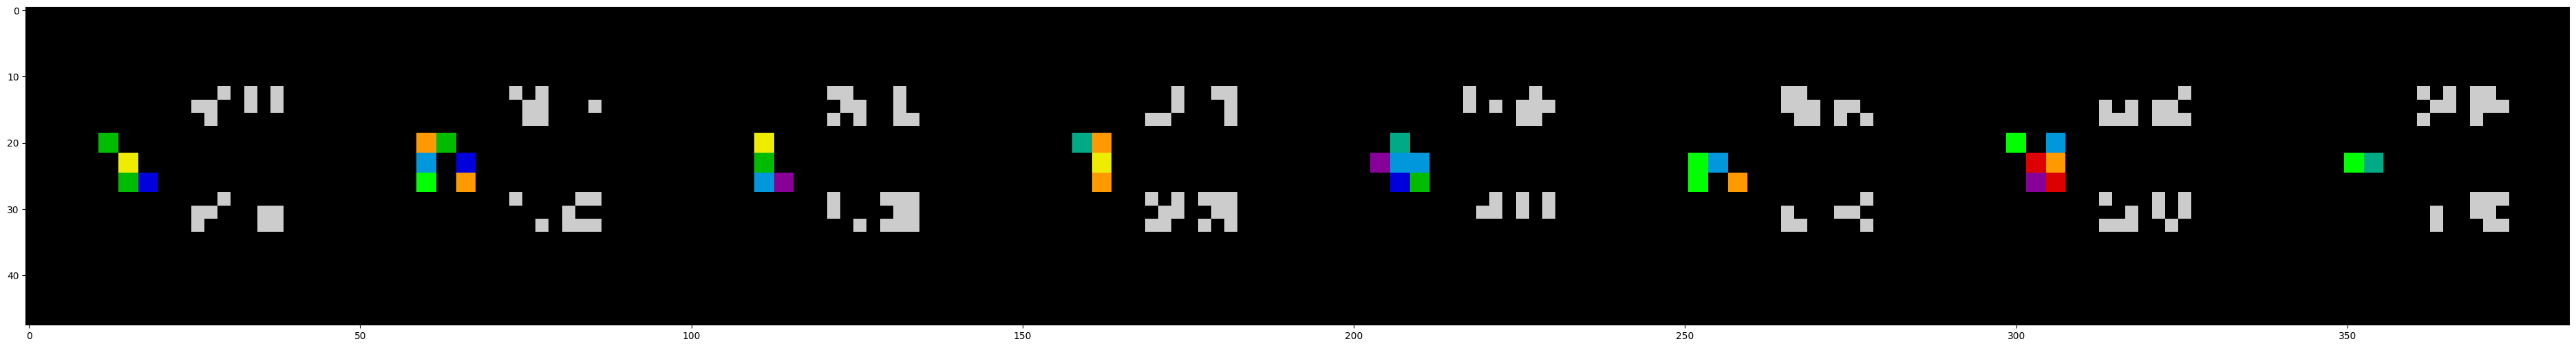

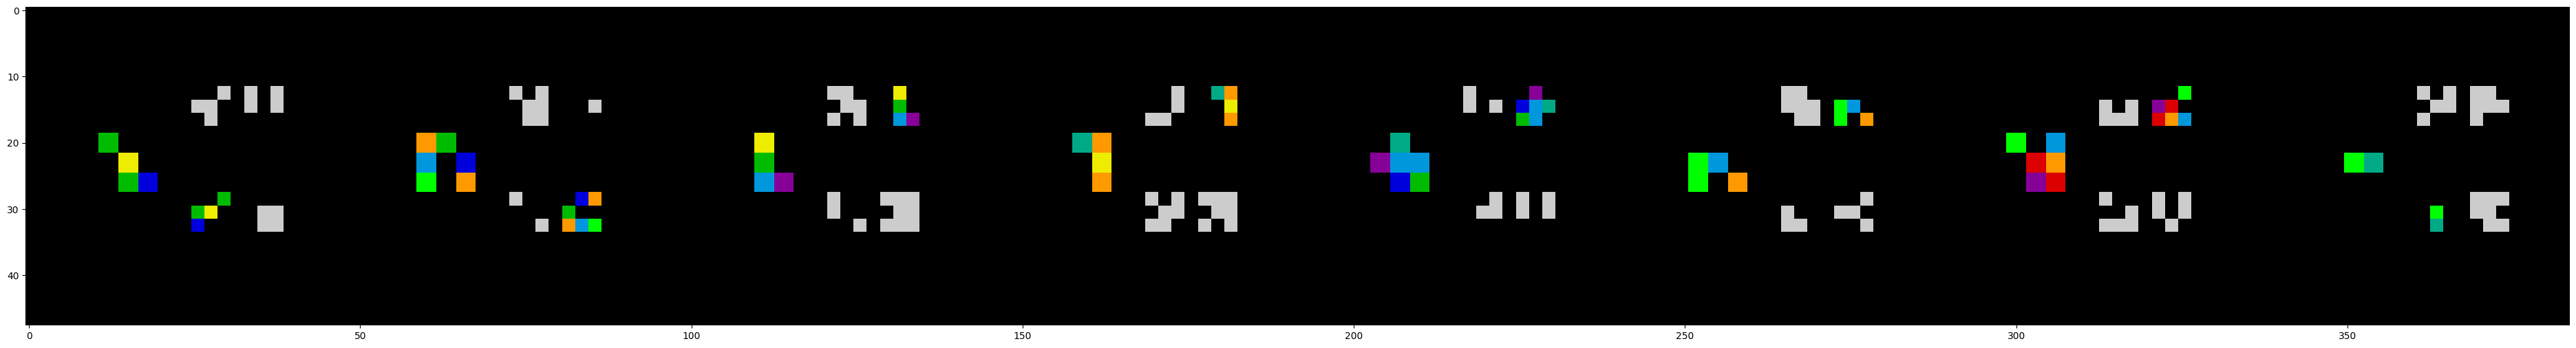

In [38]:
dataset = MatchPatternDataset()
loader = torch.utils.data.DataLoader(dataset, batch_size=8)
batch, target = next(iter(loader))

batch = torch.cat([F.pad(b, (8,8,8,8)) for b in batch.unbind()], -1)
plt.figure(figsize=(48,6))
plt.imshow(batch.permute(1,2,0).mul(24).numpy(), cmap="nipy_spectral")
plt.show()

target = torch.cat([F.pad(t, (8,8,8,8)) for t in target.unbind()], -1)
plt.figure(figsize=(48,6))
plt.imshow(target.permute(1,2,0).mul(24).numpy(), cmap="nipy_spectral")
plt.show()
